In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)

In [17]:
   
def calc_xcorr_pair_mu(ref, iir:int, search, iis:int, fs=None):
    """Calcculate normalized cross correlation"""
    from dispest.exceptions import XCorrException
    import numpy as np
    if (np.ndim(ref) != 1) or (np.ndim(search) != 1): raise XCorrException('Reference and search vectors must be 1D')

    if len(ref) > len(search)+2: raise XCorrException("Reference kernel is larger than the search kernel")

    Nref = len(ref)
    Ncomp = len(search) - Nref

    # reslice the pair
    it = np.arange(Nref, dtype=int).reshape(1,-1)
    ilag = np.arange(Ncomp, dtype=int).reshape(-1,1)
    indices = it + ilag
    sersel = search[indices]

    # format matrices
    __mu = np.mean(sersel, axis=1).reshape(-1,1)
    __search = sersel - __mu
    __ref = ref.reshape(1,-1) - np.mean(ref)

    # calculate cross correlation terms
    __cross = np.sum(__search * __ref, axis=1)
    __selfr = np.var(__ref, axis=1)
    __selfs = np.var(__search, axis=1)

    __denom = np.sqrt(__selfr * __selfs)

    rho = __cross/__denom
    
    irho = np.argmax(np.abs(rho))
    logger.info(f"Peak found at index {irho}")

    # ensure point is within search range - cant poly fit if at edge
    if (irho == 0) and (irho == len(rho)-1):
        raise XCorrException("Max was found at edge of correlation")
    
    # estimate time and value of peak with quadratic fit
    fit = np.polyfit(np.arange(irho-1, irho+2), rho[(irho-1):(irho+2)], deg=2)
    ipeak = -fit[1]/(2*fit[0])
    rho_max = np.polyval(fit, ipeak)

    # convert to shifted index
    di = iir - iis - ipeak

    # shift returned in units of indices
    if fs is None:
        logger.info("No sampling frequency given. Units are in indices")
        return di, rho_max
    
    # shift returned in units of time
    logger.info("Converting shift to time.")
    return di/fs, rho_max


In [11]:
from dispest import calc_xcorr_pair

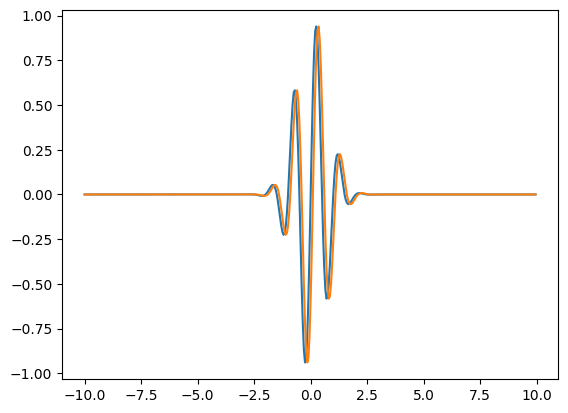

In [15]:
t = np.arange(-10,10, 0.05)
sig1 = np.exp(-(t/1)**2)*np.sin(2*np.pi*t)
sig2 = np.exp(-((t-0.1)/1)**2)*np.sin(2*np.pi*(t - 0.1))

plt.figure()
plt.plot(t, sig1)
plt.plot(t, sig2)
plt.show()
tstart = np.argmax((t>=-5) & (t<= 5))
dt_est, ho = calc_xcorr_pair_mu(sig2[(t>=-5) & (t<= 5)], tstart, sig1, 0, fs=1/0.05)

In [18]:
from timeit import timeit

ref = sig2[(t>=-5) & (t<= 5)]

dt = timeit(lambda: calc_xcorr_pair_mu(ref, tstart, sig1, 0, fs=1/0.05), number=int(1E4))/1E4
print("New", 1E6*dt, 'us')

dt = timeit(lambda: calc_xcorr_pair(ref, tstart, sig1, 0, fs=1/0.05), number=int(1E4))/1E4
print("Scipy", 1E6*dt, 'us')

New 364.4042230997002 us
Scipy 129.64225210016593 us
